In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the PINN network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        input_tensor = torch.cat((x, t), dim=1)
        return self.net(input_tensor)

# Define the traditional ANN network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        input_tensor = torch.cat((x, t), dim=1)
        return self.net(input_tensor)

In [3]:
# Define the physics loss function for PINN
def physics_loss(model, x, t, alpha=0.1):
    x.requires_grad = True
    t.requires_grad = True

    u = model(x, t)

    # Compute derivatives using autograd
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Heat equation residual
    residual = u_t - alpha * u_xx
    return torch.mean(residual**2)

In [4]:
# Generate training data
N = 20  # Number of training points
x_train = torch.rand((N, 1)) * 2 - 1  # x in [-1, 1]
t_train = torch.rand((N, 1)) * 2 - 1  # t in [-1, 1]

# Define boundary conditions with noise
noise_level = 0.1
u_exact = torch.sin(torch.pi * x_train)  # True function: sin(pi*x)
u_noisy = u_exact + noise_level * torch.randn_like(u_exact)  # Noisy data


In [5]:
# Initialize models and optimizers
pinn_model = PINN()
ann_model = ANN()
optimizer_pinn = optim.Adam(pinn_model.parameters(), lr=0.01)
optimizer_ann = optim.Adam(ann_model.parameters(), lr=0.01)

# Training PINN
epochs = 5000
for epoch in range(epochs):
    optimizer_pinn.zero_grad()

    # Compute loss: data loss + physics loss
    u_pred = pinn_model(x_train, torch.zeros_like(t_train))  # Initial condition prediction
    loss_data = torch.mean((u_pred - u_noisy) ** 2)  # Match noisy data
    loss_physics = physics_loss(pinn_model, x_train, t_train)  # Enforce PDE

    loss = loss_data + loss_physics

    # Backpropagation
    loss.backward()
    optimizer_pinn.step()

    # Training ANN
    optimizer_ann.zero_grad()
    u_ann_pred = ann_model(x_train, torch.zeros_like(t_train))
    loss_ann = torch.mean((u_ann_pred - u_noisy) ** 2)  # ANN only uses noisy data
    loss_ann.backward()
    optimizer_ann.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, PINN Loss: {loss.item():.6f}, ANN Loss: {loss_ann.item():.6f}")

print("Training complete!")

Epoch 0, PINN Loss: 0.499936, ANN Loss: 0.550582
Epoch 500, PINN Loss: 0.004259, ANN Loss: 0.002476
Epoch 1000, PINN Loss: 0.003037, ANN Loss: 0.002438
Epoch 1500, PINN Loss: 0.003004, ANN Loss: 0.002335
Epoch 2000, PINN Loss: 0.002957, ANN Loss: 0.002451
Epoch 2500, PINN Loss: 0.002733, ANN Loss: 0.002091
Epoch 3000, PINN Loss: 0.002684, ANN Loss: 0.002020
Epoch 3500, PINN Loss: 0.035954, ANN Loss: 0.002439
Epoch 4000, PINN Loss: 0.002476, ANN Loss: 0.002177
Epoch 4500, PINN Loss: 0.001735, ANN Loss: 0.002044
Training complete!


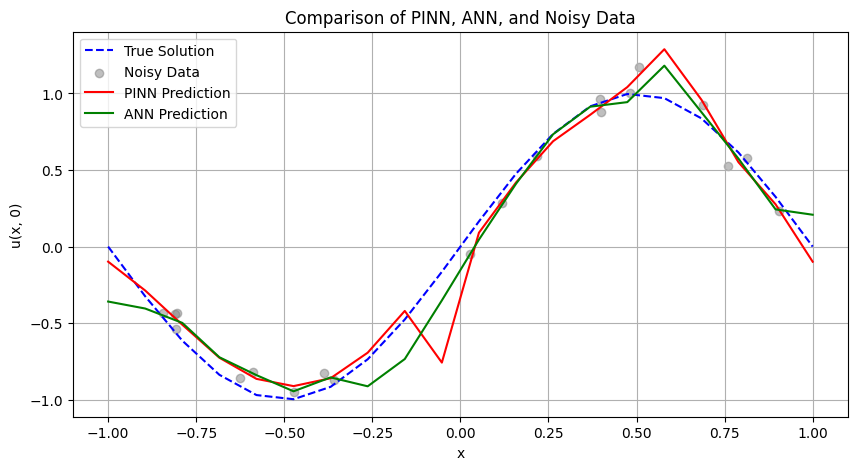

In [6]:

# ==== Visualization ====
# Generate test data for plotting
x_test = torch.linspace(-1, 1, 20).view(-1, 1)
t_test = torch.zeros_like(x_test)  # Predict at t = 0

# Compute true, noisy, and predicted values
u_true = torch.sin(torch.pi * x_test).detach().numpy()  # Ground truth
u_noisy_sample = u_noisy.detach().numpy()  # Sample noisy data
u_pinn_pred = pinn_model(x_test, t_test).detach().numpy()  # PINN Prediction
u_ann_pred = ann_model(x_test, t_test).detach().numpy()  # ANN Prediction

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(x_test.detach().numpy(), u_true, label="True Solution", linestyle="dashed", color="blue")
plt.scatter(x_train.detach().numpy(), u_noisy_sample, label="Noisy Data", color="gray", alpha=0.5)
plt.plot(x_test.detach().numpy(), u_pinn_pred, label="PINN Prediction", color="red")
plt.plot(x_test.detach().numpy(), u_ann_pred, label="ANN Prediction", color="green")
plt.xlabel("x")
plt.ylabel("u(x, 0)")
plt.title("Comparison of PINN, ANN, and Noisy Data")
plt.legend()
plt.grid()
plt.show()


Epoch 0, PINN Loss: 0.499816, ANN Loss: 0.557668
Epoch 500, PINN Loss: 0.009508, ANN Loss: 0.009275
Epoch 1000, PINN Loss: 0.009477, ANN Loss: 0.009418
Epoch 1500, PINN Loss: 0.009463, ANN Loss: 0.009277
Epoch 2000, PINN Loss: 0.009453, ANN Loss: 0.009281
Epoch 2500, PINN Loss: 0.009449, ANN Loss: 0.009440
Epoch 3000, PINN Loss: 0.009492, ANN Loss: 0.009185
Epoch 3500, PINN Loss: 0.009448, ANN Loss: 0.009220
Epoch 4000, PINN Loss: 0.009444, ANN Loss: 0.009222
Epoch 4500, PINN Loss: 0.009460, ANN Loss: 0.009224
Training complete!


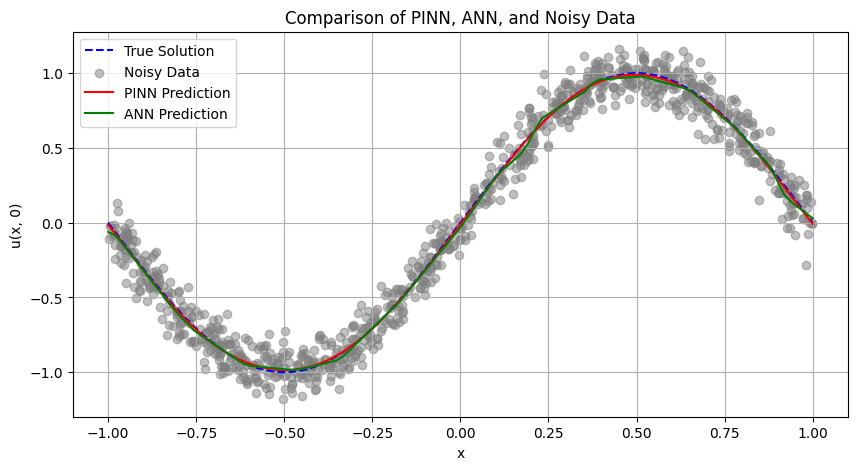

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the PINN network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        input_tensor = torch.cat((x, t), dim=1)
        return self.net(input_tensor)

# Define the traditional ANN network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        input_tensor = torch.cat((x, t), dim=1)
        return self.net(input_tensor)

# Define the physics loss function for PINN
def physics_loss(model, x, t, alpha=0.01):
    x.requires_grad = True
    t.requires_grad = True

    u = model(x, t)

    # Compute derivatives using autograd
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Heat equation residual
    residual = u_t - alpha * u_xx
    return torch.mean(residual**2)

# Generate training data
N = 1000  # Number of training points
x_train = torch.rand((N, 1)) * 2 - 1  # x in [-1, 1]
t_train = torch.rand((N, 1)) * 2 - 1  # t in [-1, 1]

# Define boundary conditions with noise
noise_level = 0.1
u_exact = torch.sin(torch.pi * x_train)  # True function: sin(pi*x)
u_noisy = u_exact + noise_level * torch.randn_like(u_exact)  # Noisy data

# Initialize models and optimizers
pinn_model = PINN()
ann_model = ANN()
optimizer_pinn = optim.Adam(pinn_model.parameters(), lr=0.01)
optimizer_ann = optim.Adam(ann_model.parameters(), lr=0.01)

# Training PINN
epochs = 5000
for epoch in range(epochs):
    optimizer_pinn.zero_grad()

    # Compute loss: data loss + physics loss
    u_pred = pinn_model(x_train, torch.zeros_like(t_train))  # Initial condition prediction
    loss_data = torch.mean((u_pred - u_noisy) ** 2)  # Match noisy data
    loss_physics = physics_loss(pinn_model, x_train, t_train)  # Enforce PDE

    loss = loss_data + loss_physics

    # Backpropagation
    loss.backward()
    optimizer_pinn.step()

    # Training ANN
    optimizer_ann.zero_grad()
    u_ann_pred = ann_model(x_train, torch.zeros_like(t_train))
    loss_ann = torch.mean((u_ann_pred - u_noisy) ** 2)  # ANN only uses noisy data
    loss_ann.backward()
    optimizer_ann.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, PINN Loss: {loss.item():.6f}, ANN Loss: {loss_ann.item():.6f}")

print("Training complete!")

# ==== Visualization ====
# Generate test data for plotting
x_test = torch.linspace(-1, 1, 100).view(-1, 1)
t_test = torch.zeros_like(x_test)  # Predict at t = 0

# Compute true, noisy, and predicted values
u_true = torch.sin(torch.pi * x_test).detach().numpy()  # Ground truth
u_noisy_sample = u_noisy.detach().numpy()  # Sample noisy data
u_pinn_pred = pinn_model(x_test, t_test).detach().numpy()  # PINN Prediction
u_ann_pred = ann_model(x_test, t_test).detach().numpy()  # ANN Prediction

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(x_test.detach().numpy(), u_true, label="True Solution", linestyle="dashed", color="blue")
plt.scatter(x_train.detach().numpy(), u_noisy_sample, label="Noisy Data", color="gray", alpha=0.5)
plt.plot(x_test.detach().numpy(), u_pinn_pred, label="PINN Prediction", color="red")
plt.plot(x_test.detach().numpy(), u_ann_pred, label="ANN Prediction", color="green")
plt.xlabel("x")
plt.ylabel("u(x, 0)")
plt.title("Comparison of PINN, ANN, and Noisy Data")
plt.legend()
plt.grid()
plt.show()
